<a href="https://colab.research.google.com/github/Tclack88/covid19/blob/master/SEIR_Model_Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure to open in colab to see the plots!


You might want to change the plot sizes; just ctrl+f for "figsize" and change them all (ex.: (20,4) to (10,2))

# Imports

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams
from matplotlib import ticker
%matplotlib inline 
# !pip install mpld3
# import mpld3
# mpld3.enable_notebook()  #Interfere's with matplotlib's axis scaler (symlog and logit unavailable)

from scipy.integrate import odeint
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 266kB 2.7MB/s 
     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 256kB 8.7MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.1-cp36-none-any.whl size=81990 sha256=b758f8be4cd14028ff71c43ba44a674d1baeea429b64292e48d2afa6ec39d8f8
  Stored in directory: /root/.cache/pip/wheels/ef/22/8d/6cd9c0af36f501cfb248673b05dad5d2c27504951d55519acb
  Created wheel for asteval: filename=asteval-0.9.18-cp36-none-any.whl size=17381 sha256=59b1effbd8e752987fe5b20af3111a8ed62b3aba0622f76c2e5f4b08fe8de8c9
  Stored in directory: /root/.cache/pip/wheels/1c/53/1b/28d929700c9633b1786a4982e6db564ec8326a8930234dcc19
Successfully built lmfit asteval


#Simple SIR

In [2]:
sir_dead_data = pd.read_csv("https://data.humdata.org/hxlproxy/data/download/time_series_covid19_deaths_global_narrow.csv?dest=data_edit&filter01=merge&merge-url01=https%3A%2F%2Fdocs.google.com%2Fspreadsheets%2Fd%2Fe%2F2PACX-1vTglKQRXpkKSErDiWG6ycqEth32MY0reMuVGhaslImLjfuLU0EUgyyu2e-3vKDArjqGX7dXEBV8FJ4f%2Fpub%3Fgid%3D1326629740%26single%3Dtrue%26output%3Dcsv&merge-keys01=%23country%2Bname&merge-tags01=%23country%2Bcode%2C%23region%2Bmain%2Bcode%2C%23region%2Bsub%2Bcode%2C%23region%2Bintermediate%2Bcode&filter02=merge&merge-url02=https%3A%2F%2Fdocs.google.com%2Fspreadsheets%2Fd%2Fe%2F2PACX-1vTglKQRXpkKSErDiWG6ycqEth32MY0reMuVGhaslImLjfuLU0EUgyyu2e-3vKDArjqGX7dXEBV8FJ4f%2Fpub%3Fgid%3D398158223%26single%3Dtrue%26output%3Dcsv&merge-keys02=%23adm1%2Bname&merge-tags02=%23country%2Bcode%2C%23region%2Bmain%2Bcode%2C%23region%2Bsub%2Bcode%2C%23region%2Bintermediate%2Bcode&merge-replace02=on&merge-overwrite02=on&filter03=explode&explode-header-att03=date&explode-value-att03=value&filter04=rename&rename-oldtag04=%23affected%2Bdate&rename-newtag04=%23date&rename-header04=Date&filter05=rename&rename-oldtag05=%23affected%2Bvalue&rename-newtag05=%23affected%2Binfected%2Bvalue%2Bnum&rename-header05=Value&filter06=clean&clean-date-tags06=%23date&filter07=sort&sort-tags07=%23date&sort-reverse07=on&filter08=sort&sort-tags08=%23country%2Bname%2C%23adm1%2Bname&tagger-match-all=on&tagger-default-tag=%23affected%2Blabel&tagger-01-header=province%2Fstate&tagger-01-tag=%23adm1%2Bname&tagger-02-header=country%2Fregion&tagger-02-tag=%23country%2Bname&tagger-03-header=lat&tagger-03-tag=%23geo%2Blat&tagger-04-header=long&tagger-04-tag=%23geo%2Blon&header-row=1&url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_deaths_global.csv",
                            parse_dates=["Date"], skiprows=[1])
sir_recovered_data = pd.read_csv("https://data.humdata.org/hxlproxy/data/download/time_series_covid19_recovered_global_narrow.csv?dest=data_edit&filter01=merge&merge-url01=https%3A%2F%2Fdocs.google.com%2Fspreadsheets%2Fd%2Fe%2F2PACX-1vTglKQRXpkKSErDiWG6ycqEth32MY0reMuVGhaslImLjfuLU0EUgyyu2e-3vKDArjqGX7dXEBV8FJ4f%2Fpub%3Fgid%3D1326629740%26single%3Dtrue%26output%3Dcsv&merge-keys01=%23country%2Bname&merge-tags01=%23country%2Bcode%2C%23region%2Bmain%2Bcode%2C%23region%2Bsub%2Bcode%2C%23region%2Bintermediate%2Bcode&filter02=merge&merge-url02=https%3A%2F%2Fdocs.google.com%2Fspreadsheets%2Fd%2Fe%2F2PACX-1vTglKQRXpkKSErDiWG6ycqEth32MY0reMuVGhaslImLjfuLU0EUgyyu2e-3vKDArjqGX7dXEBV8FJ4f%2Fpub%3Fgid%3D398158223%26single%3Dtrue%26output%3Dcsv&merge-keys02=%23adm1%2Bname&merge-tags02=%23country%2Bcode%2C%23region%2Bmain%2Bcode%2C%23region%2Bsub%2Bcode%2C%23region%2Bintermediate%2Bcode&merge-replace02=on&merge-overwrite02=on&filter03=explode&explode-header-att03=date&explode-value-att03=value&filter04=rename&rename-oldtag04=%23affected%2Bdate&rename-newtag04=%23date&rename-header04=Date&filter05=rename&rename-oldtag05=%23affected%2Bvalue&rename-newtag05=%23affected%2Binfected%2Bvalue%2Bnum&rename-header05=Value&filter06=clean&clean-date-tags06=%23date&filter07=sort&sort-tags07=%23date&sort-reverse07=on&filter08=sort&sort-tags08=%23country%2Bname%2C%23adm1%2Bname&tagger-match-all=on&tagger-default-tag=%23affected%2Blabel&tagger-01-header=province%2Fstate&tagger-01-tag=%23adm1%2Bname&tagger-02-header=country%2Fregion&tagger-02-tag=%23country%2Bname&tagger-03-header=lat&tagger-03-tag=%23geo%2Blat&tagger-04-header=long&tagger-04-tag=%23geo%2Blon&header-row=1&url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_recovered_global.csv",
                             parse_dates=["Date"], skiprows=[1]) # ONLY FOR simple SIR, this is data of the recovered
confirmed = "https://data.humdata.org/hxlproxy/data/download/time_series_covid19_confirmed_global_narrow.csv?dest=data_edit&filter01=merge&merge-url01=https%3A%2F%2Fdocs.google.com%2Fspreadsheets%2Fd%2Fe%2F2PACX-1vTglKQRXpkKSErDiWG6ycqEth32MY0reMuVGhaslImLjfuLU0EUgyyu2e-3vKDArjqGX7dXEBV8FJ4f%2Fpub%3Fgid%3D1326629740%26single%3Dtrue%26output%3Dcsv&merge-keys01=%23country%2Bname&merge-tags01=%23country%2Bcode%2C%23region%2Bmain%2Bcode%2C%23region%2Bsub%2Bcode%2C%23region%2Bintermediate%2Bcode&filter02=merge&merge-url02=https%3A%2F%2Fdocs.google.com%2Fspreadsheets%2Fd%2Fe%2F2PACX-1vTglKQRXpkKSErDiWG6ycqEth32MY0reMuVGhaslImLjfuLU0EUgyyu2e-3vKDArjqGX7dXEBV8FJ4f%2Fpub%3Fgid%3D398158223%26single%3Dtrue%26output%3Dcsv&merge-keys02=%23adm1%2Bname&merge-tags02=%23country%2Bcode%2C%23region%2Bmain%2Bcode%2C%23region%2Bsub%2Bcode%2C%23region%2Bintermediate%2Bcode&merge-replace02=on&merge-overwrite02=on&filter03=explode&explode-header-att03=date&explode-value-att03=value&filter04=rename&rename-oldtag04=%23affected%2Bdate&rename-newtag04=%23date&rename-header04=Date&filter05=rename&rename-oldtag05=%23affected%2Bvalue&rename-newtag05=%23affected%2Binfected%2Bvalue%2Bnum&rename-header05=Value&filter06=clean&clean-date-tags06=%23date&filter07=sort&sort-tags07=%23date&sort-reverse07=on&filter08=sort&sort-tags08=%23country%2Bname%2C%23adm1%2Bname&tagger-match-all=on&tagger-default-tag=%23affected%2Blabel&tagger-01-header=province%2Fstate&tagger-01-tag=%23adm1%2Bname&tagger-02-header=country%2Fregion&tagger-02-tag=%23country%2Bname&tagger-03-header=lat&tagger-03-tag=%23geo%2Blat&tagger-04-header=long&tagger-04-tag=%23geo%2Blon&header-row=1&url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv"
sir_confirmed_data = pd.read_csv(confirmed, parse_dates=["Date"], skiprows=[1])

In [3]:
sir_confirmed_data = sir_confirmed_data[["Country/Region", "Date","ISO 3166-1 Alpha 3-Codes", "Value"]]
sir_dead_data = sir_dead_data[["Country/Region", "Date","ISO 3166-1 Alpha 3-Codes", "Value"]]
sir_recovered_data = sir_recovered_data[["Country/Region", "Date","ISO 3166-1 Alpha 3-Codes", "Value"]]

In [4]:
test_merge = pd.merge(sir_dead_data,sir_recovered_data, on=["Country/Region", "Date","ISO 3166-1 Alpha 3-Codes"],how='left')
print(test_merge.shape) #off, but it doesn't affect the countries we are interested in
test_merge['Value'] = test_merge.Value_x + test_merge.Value_y
test_merge.head()

(219100, 5)


,Country/Region,Date,ISO 3166-1 Alpha 3-Codes,Value_x,Value_y,Value
0,Afghanistan,2020-07-14,AFG,1048,21454.0,22502.0
1,Afghanistan,2020-07-13,AFG,1012,21254.0,22266.0
2,Afghanistan,2020-07-12,AFG,1010,21216.0,22226.0
3,Afghanistan,2020-07-11,AFG,994,21135.0,22129.0
4,Afghanistan,2020-07-10,AFG,971,20882.0,21853.0


In [5]:
sir_covid_data = test_merge
sir_covid_data = sir_dead_data
sir_covid_data["Location"] = sir_covid_data["Country/Region"]
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")

In [6]:
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))

In [16]:
# Need this to set months to x-axis
full_days = 200

# first_date = np.datetime64(sir_covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")

In [15]:
def sir_deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [ ]:
# # parameters
# data = sir_covid_data[sir_covid_data["Location"] == "Brazil"]["Value"].values[::-1] # for all other countries
# # data = sir_covid_data[sir_covid_data["ISO 3166-1 Alpha 3-Codes"] == "GBR"]['Value'].values[::-1] #for UK only (courtesy of the British Empire)
# country_agegroups = agegroup_lookup["Brazil"]

# params_init_min_max = {"beta": (.33, 0, 5), "gamma": (.11, 0, 15)} # form: {parameter: (initial guess, minimum value, max value)}

In [13]:
# days = len(data)
# y_data = data # numpy array of total recovered each day
# x_data = np.linspace(0, days - 1, days, dtype=int)  # numpy array [0,1,2,...toatal days]

#initial guesses based on news reports
# beta = 1/3 # guess  since Ro = beta/gamma ~ 3
# gamma = 1/9

def sir_Model(full_days=None, beta=1/3, gamma=1/9):
    # specific params
    N = sum(country_agegroups)
    y0 = (N-1,1,0)
    t = np.linspace(0, days-1, days)
    if full_days:
      t = np.linspace(0, full_days - 1, full_days)
    # ODE solver
    ret = odeint(sir_deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    return t, S, I, R

In [26]:
# OLD 3
# def plotsir(t, S, I, R, x_ticks=None):
#   f, ax = plt.subplots(1,1,figsize=(10,4))
#   if x_ticks is None:
#     ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
#     ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
#     ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
#   else:
#     ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
#     ax.plot(x_ticks, I, 'y', alpha=0.7, linewidth=2, label='Infected')
#     ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

#   ax.set_xlabel('Time (Month)')
#   ax.set_ylabel('Number of People')
#   ax.set_title(title)
  

#   formatter = ticker.ScalarFormatter(useMathText=True)
#   formatter.set_scientific(False) 
#   # ax.yaxis.set_major_formatter(formatter) 

#   ax.yaxis.set_major_formatter(formatter) 
#   ax.xaxis.set_major_locator(mdates.YearLocator())
#   ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#   ax.xaxis.set_minor_locator(mdates.MonthLocator())
#   f.autofmt_xdate()

#   ax.yaxis.set_tick_params(length=0)
#   ax.xaxis.set_tick_params(length=0)
#   ax.grid(b=True, which='major', c='w', lw=2, ls='-')
#   legend = ax.legend()
#   legend.get_frame().set_alpha(0.5)
#   for spine in ('top', 'right', 'bottom', 'left'):
#       ax.spines[spine].set_visible(False)
#   plt.xlim(60,len(S))
#   plt.show();


#OLD 1
# def plotsir_top(t, S, I, R):
#   f, ax = plt.subplots(1,1,figsize=(10,4))
#   ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
#   # ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
#   # ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

#   ax.set_xlabel('Time (days)')

#   ax.yaxis.set_tick_params(length=0)
#   ax.xaxis.set_tick_params(length=0)
#   ax.grid(b=True, which='major', c='w', lw=2, ls='-')
#   legend = ax.legend()
#   legend.get_frame().set_alpha(0.5)
#   for spine in ('top', 'right', 'bottom', 'left'):
#       ax.spines[spine].set_visible(False)
#   plt.xlim(60,len(S))
#   plt.show();


#OLD 2
# def plotsir_bottom(t, S, I, R):
#   f, ax = plt.subplots(1,1,figsize=(10,4))
#   # ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
#   ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
#   ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

#   ax.set_xlabel('Time (days)')

#   ax.yaxis.set_tick_params(length=0)
#   ax.xaxis.set_tick_params(length=0)
#   ax.grid(b=True, which='major', c='w', lw=2, ls='-')
#   legend = ax.legend()
#   legend.get_frame().set_alpha(0.5)
#   for spine in ('top', 'right', 'bottom', 'left'):
#       ax.spines[spine].set_visible(False)
#   plt.xlim(60,len(S))
#   plt.show();

def plotsir(t, S, I, R):
  fig, axs = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(6,6),frameon=False)
  S,I,R = S/1000000,I/1000000,R/1000000 # divide by 1,000,000 to keep y axis small (in millions)
  # come back and figure this out
  # if x_ticks == None:
  #   axs[0].plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  #   axs[1].plot(x_ticks, I, 'y', alpha=0.7, linewidth=2, label='Infected')
  #   axs[1].plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  # else:
  #   axs[0].plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  #   axs[1].plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
  #   axs[1].plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  axs[0].plot(t, S, 'y', alpha=0.7, linewidth=2, label='Infected')
  axs[0].plot(t, S, 'g', alpha=0.7, linewidth=2, label='Removed')
  axs[0].plot(t, S, 'b', alpha=1, linewidth=2, label='Susceptible') # changed order to keep S on top to confine legend to single plot. Hacky at best...
  axs[1].plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
  axs[1].plot(t, R, 'g', alpha=0.7, linewidth=2, label='Removed')
  # print(max(S),max(I), max(R))
  # print(len(t),len(x_ticks))

  formatter = ticker.ScalarFormatter(useMathText=True)
  formatter.set_scientific(False) 
  axs[0].yaxis.set_major_formatter(formatter) 
  axs[1].yaxis.set_major_formatter(formatter) 

  # Come back and figure this out
  # axs[1].yaxis.set_major_formatter(formatter) 
  # axs[0].xaxis.set_major_locator(mdates.YearLocator())
  # axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
  # axs[0].xaxis.set_minor_locator(mdates.MonthLocator())
  # fig.autofmt_xdate()

  # sets and locates the months
  labels = ["February", "March","April", "May", "June", "July", "August"]
  axs[1].set_xticks([30, 60, 85,115,145,175,200])
  axs[1].set_xticklabels(labels)
  legend = axs[0].legend()
  legend.get_frame().set_alpha(0.5)

  for ax in axs:
    ax.grid(True)
    # custom grid appearance
    ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
    for tic in ax.xaxis.get_major_ticks():
      tic.tick1On = tic.tick2On = False
    for tic in ax.yaxis.get_major_ticks():
      tic.tick1On = tic.tick2On = False
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

  axs[1].set_ylim(0,max(I)*3)

  fig.suptitle(plot_title) # plot_title is global
  
  # plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

  plt.xlabel('Time (Month)')
  fig.text(0.0, 0.5, 'Number of People (Million)', va='center', ha='center', rotation='vertical', fontsize=rcParams['axes.labelsize'])
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

# Leave here for hopeless debugging the the future :[ (run cells below if error, it's only here to reduce death by scrolling)
# plot_title = 'test title'
# plotsir(*sir_Model())

In [ ]:
# country_agegroups = agegroup_lookup["US"]
# plotsir(*sir_Model())
# This is a generic plot, showing the model works with the base SIR model
# and to verify the solutions to the diff.EQ's are sensible.
# it has not been fitted with any real world data and takes default
# values for Beta and Gamma (1/3 and 1/9)

## Brazil SIR

In [10]:
# parameters
country = "Brazil"  # need for herd immunity lookup as global variable
data = sir_covid_data[sir_covid_data["Location"] == country]["Value"].values[::-1] # for all other countries
# data = sir_covid_data[sir_covid_data["ISO 3166-1 Alpha 3-Codes"] == "GBR"]['Value'].values[::-1] #for UK only (courtesy of the British Empire)
country_agegroups = agegroup_lookup[country]

days = len(data)
full_days = 200 # amount of days to show in plot to extend predictions

# IMPLEMENT SHIFT?!?!? Here goes nothing
# outbreak_shift must be negative to remove zeros in the front, positive to add
outbreak_shift = 56
days = outbreak_shift + len(data)
y_data = data
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

    

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array
# Need this to set months to x-axis!
first_date = np.datetime64(sir_covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
# y_data = data # numpy array of total recovered each day   # THIS MOTHERFUCKER HAS BEEN CAUSING ME ISSUES (Keep for historical purposes so I can look back at it and hate upon it)
# x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D") # Watch out for this one too.... potentially useful if I can ever get the dates to match without hard-coding
x_data = np.linspace(0, days - 1, days, dtype=int)  # numpy array [0,1,2,...total days]

In [ ]:
# days

In [ ]:
# first_date

In [11]:
def wrapper(x, beta, gamma, full_days=None):
    ret = sir_Model(full_days, beta, gamma)
    return ret[2] # 2 corresponds to the output of sir_Model: I, i.e. infected which should match with our y_data in lmfit.Model (we give as confirmed cases)

mod = lmfit.Model(wrapper)

params_init_min_max = {"beta": (.33, 0, 5), "gamma": (.11, 0, 15)} # form: {parameter: (initial guess, minimum value, max value)}

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

mod.independent_vars
params = mod.make_params()
fit_method = "leastsq"

In [17]:
result = mod.fit(y_data, params, method=fit_method, x=x_data)
result.best_values

{'beta': 2.230062490246652, 'gamma': 2.1742418145912197}

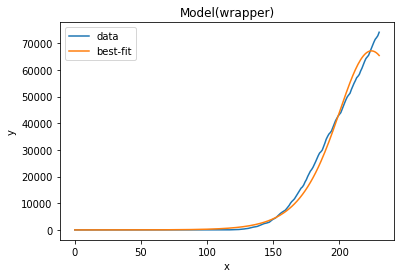

In [18]:
result.plot_fit(datafmt="-");

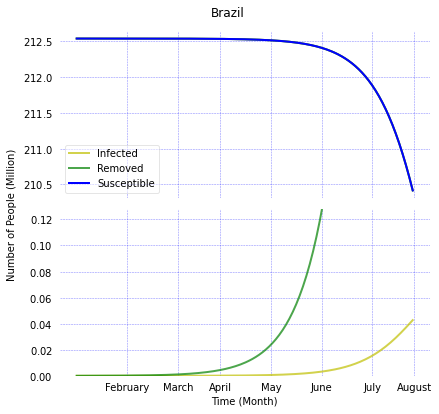

In [27]:
plot_title = country
plotsir(*sir_Model(full_days, **result.best_values))

In [ ]:
# plotsir_top(*sir_Model(full_days, **result.best_values))

In [ ]:
# plotsir_bottom(*sir_Model(full_days, **result.best_values))

### SIR Brazil with Vaccine

In [28]:
# Herd imunity calculated from 1- 1/R where R is the reproduction number. The values here corresponde to the averages of the values in the SEIRC model
# So yeah..... using the future of this notebook for the present
herd_lookup = {'United States': .64, 'United Kingdom': .59, 'Brazil': .57}
# Anyway, these represent the proportion of the population that need to be immunized to prevent the further spreading of the disease

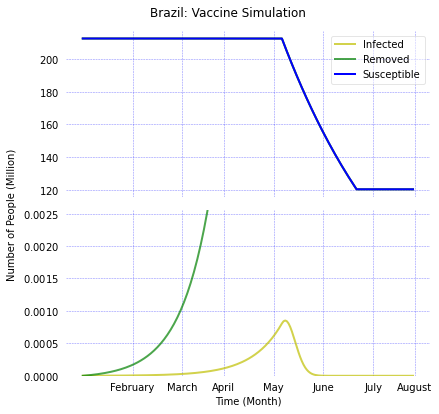

In [29]:
def vac_sir_deriv(y, t, N, beta, gamma):
    S, I, R = y
    herd_immunity = herd_lookup[country]
    factor = herd_immunity * S  # N = country population, vs S = currently susceptible people, herd_immunity = fraction of population that must be immunized
    # print(herd_immunity, N, factor)
    days_apply_vaccine = 45 # <-------------- Can Change
    num = factor / days_apply_vaccine # <---- Can Change
    vaccine_date = 120 # <------------------- Can Change
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    if vaccine_date < t < vaccine_date + days_apply_vaccine:  # apply vaccine for 30 days
        dSdt = -beta * S * I / N - num
        dRdt = gamma * I + num
    return dSdt, dIdt, dRdt


def vac_sir_Model(country, full_days=None, beta=1/3, gamma=1/9):
    # specific params
    N = sum(country_agegroups)
    y0 = (N-1,1,0)
    t = np.linspace(0, days-1, days)
    if full_days:
      t = np.linspace(0, full_days - 1, full_days)
    # ODE solver
    ret = odeint(vac_sir_deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    return t, S, I, R

plot_title = 'Brazil: Vaccine Simulation'
plotsir(*vac_sir_Model(country, full_days,**result.best_values))

In [ ]:
# plotsir_top(*vac_sir_Model(full_days,**result.best_values))

In [ ]:
# plotsir_bottom(*vac_sir_Model(full_days,**result.best_values))

### SIR Brazil with mutation

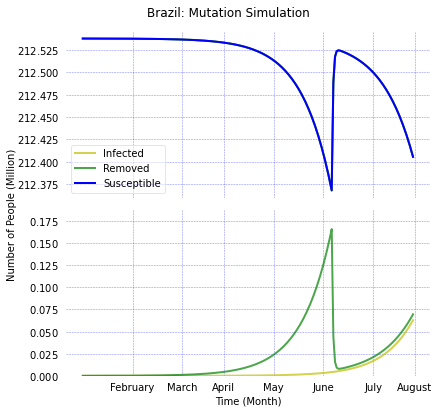

In [30]:
def mut_sir_deriv(y, t, N, beta, gamma):
    S, I, R = y
    rate = .01 # rate of resusceptability <------------------- Can Change
    T = 7 # grace period (days)          <------------------- Can Change
    mutation_date = 150 #                 <------------------- Can Change
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    if t > mutation_date:
        dSdt = -beta * S * I / N + rate * R * (t - T)
        dRdt = gamma * I - rate * R * (t - T)
    return dSdt, dIdt, dRdt

def mut_sir_Model(full_days=None, beta=1/3, gamma=1/9):
    # specific params
    N = sum(country_agegroups) #         <------------------- Can Change
    y0 = (N-1,1,0)
    t = np.linspace(0, days-1, days)
    if full_days:
      t = np.linspace(0, full_days - 1, full_days)
    # ODE solver
    ret = odeint(mut_sir_deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    return t, S, I, R

plot_title = 'Brazil: Mutation Simulation'
plotsir(*mut_sir_Model(full_days,**result.best_values))

In [ ]:
# plotsir_top(*mut_sir_Model(full_days, **result.best_values))

In [ ]:
# plotsir_bottom(*mut_sir_Model(full_days, **result.best_values))

## SIR US

In [31]:
# DATA
country = 'United States'
data = sir_covid_data[sir_covid_data["Location"] == "US"]["Value"].values[::-1] # for all other countries
# data = sir_covid_data[sir_covid_data["ISO 3166-1 Alpha 3-Codes"] == "GBR"]['Value'].values[::-1] #for UK only (courtesy of the British Empire)
country_agegroups = agegroup_lookup["US"]



days = len(data)
y_data = data # numpy array of total recovered each day

outbreak_shift = 39
days = outbreak_shift + len(data)
y_data = data # redundant probably, but I don't give a shit
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # numpy array [0,1,2,...toatal days]

In [32]:
def wrapper(x, beta, gamma,full_days=None):
    ret = sir_Model(full_days, beta, gamma)
    return ret[2] # 2 corresponds to the output of sir_Model: I, i.e. infected which should match with our y_data in lmfit.Model (we give as confirmed cases)

mod = lmfit.Model(wrapper)

params_init_min_max = {"beta": (.33, 0, 5), "gamma": (.11, 0, 15)} # form: {parameter: (initial guess, minimum value, max value)}
for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

mod.independent_vars
params = mod.make_params()
fit_method = "leastsq"

In [33]:
result = mod.fit(y_data, params, method=fit_method, x=x_data)
result.best_values

{'beta': 2.369717563621661, 'gamma': 2.298421486279758}

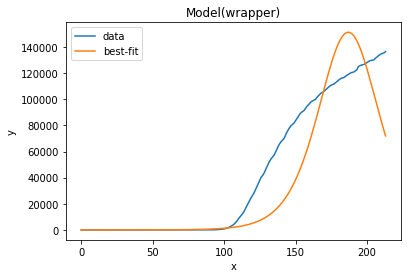

In [34]:
result.plot_fit(datafmt="-");

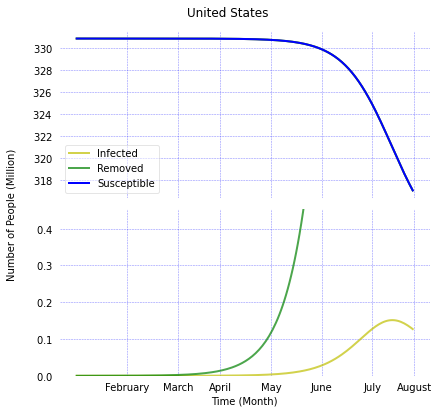

In [35]:
plot_title = 'United States'
plotsir(*sir_Model(full_days, **result.best_values))

In [ ]:
# plotsir_top(*sir_Model(full_days, **result.best_values))

In [ ]:
# plotsir_bottom(*sir_Model(full_days, **result.best_values))

### SIR US with Vaccine and Mutation

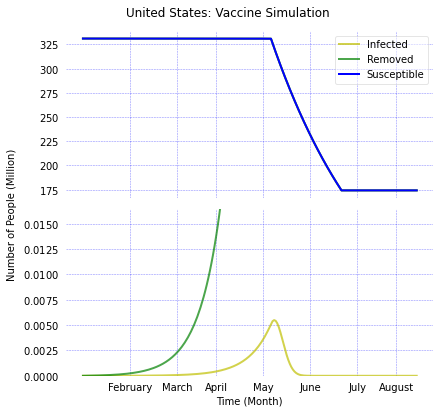

In [36]:
plot_title = "United States: Vaccine Simulation"
plotsir(*vac_sir_Model(full_days, **result.best_values))

In [ ]:
# plotsir_top(*vac_sir_Model(full_days, **result.best_values))

In [ ]:
# plotsir_bottom(*vac_sir_Model(full_days, **result.best_values))

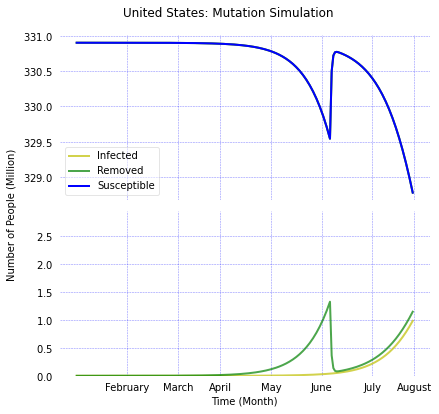

In [37]:
plot_title = "United States: Mutation Simulation"
plotsir(*mut_sir_Model(full_days, **result.best_values))


In [ ]:
# plotsir_top(*mut_sir_Model(full_days, **result.best_values))

In [ ]:
# plotsir_bottom(*mut_sir_Model(full_days, **result.best_values))

## SIR UK

In [38]:
# DATA
country = 'United Kingdom'
# data = sir_covid_data[sir_covid_data["Location"] == "United Kingdom"]["Value"].values[::-1] # for all other countries
data = sir_covid_data[sir_covid_data["ISO 3166-1 Alpha 3-Codes"] == "GBR"]['Value'].values[::-1] #for UK only (courtesy of the British Empire)
# data = data[:81] # data drops to 0 after this point which makes no sense, so to maintain highest accuract possible, it is truncated (only true for recovered)
country_agegroups = agegroup_lookup["United Kingdom"]
days = len(data)
y_data = data # numpy array of total recovered each day

outbreak_shift = 45
days = outbreak_shift + len(data)
y_data = data # redundant probably, but I don't give a shit
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]
x_data = np.linspace(0, days - 1, days, dtype=int)  # numpy array [0,1,2,...toatal days]

In [39]:
def wrapper(x, beta, gamma, full_days=None):
    ret = sir_Model(full_days, beta, gamma)
    return ret[2] # 2 corresponds to the output of sir_Model: I, i.e. infected which should match with our y_data in lmfit.Model (we give as confirmed cases)

mod = lmfit.Model(wrapper)

params_init_min_max = {"beta": (.33, 0, 5), "gamma": (.11, 0, 15)} # form: {parameter: (initial guess, minimum value, max value)}
for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

mod.independent_vars
params = mod.make_params()
fit_method = "leastsq"

In [40]:
result = mod.fit(y_data, params, method=fit_method, x=x_data)
result.best_values

{'beta': 1.6634727903714892, 'gamma': 1.598475082733417}

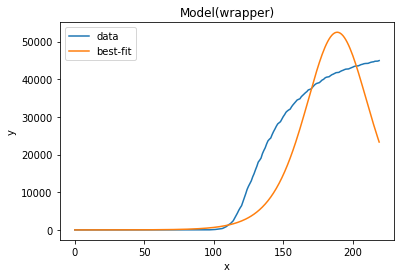

In [41]:
result.plot_fit(datafmt="-");

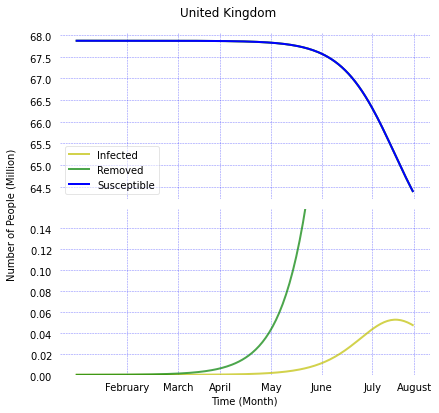

In [42]:
plot_title = 'United Kingdom'
plotsir(*sir_Model(full_days, **result.best_values))

In [ ]:
# plotsir_top(*sir_Model(full_days, **result.best_values))

In [ ]:
# plotsir_bottom(*sir_Model(full_days, **result.best_values))

### SIR UK with vaccine and mutation


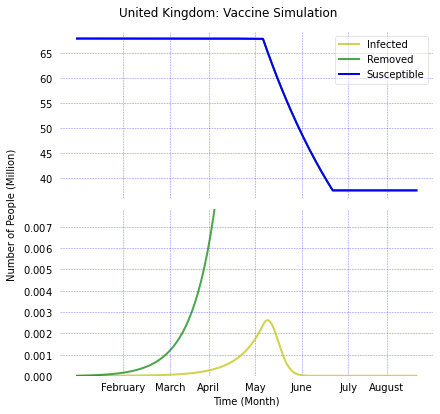

In [43]:
plot_title = "United Kingdom: Vaccine Simulation"
plotsir(*vac_sir_Model(full_days, **result.best_values))

In [ ]:
# plotsir_top(*vac_sir_Model(full_days, **result.best_values))

In [ ]:
# plotsir_bottom(*vac_sir_Model(full_days, **result.best_values))

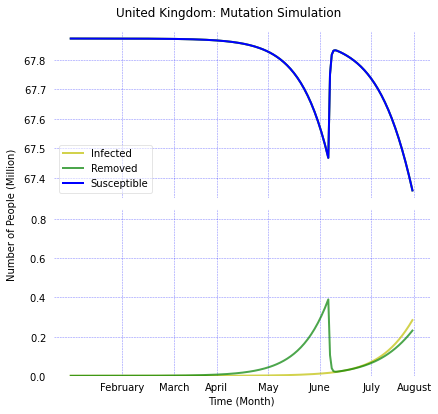

In [44]:
plot_title = "United Kingdom: Mutation Simulation"
plotsir(*mut_sir_Model(full_days, **result.best_values))

In [ ]:
# plotsir_top(*mut_sir_Model(full_days, **result.best_values))

In [ ]:
# plotsir_bottom(*mut_sir_Model(full_days, **result.best_values))

# Extended SEIR

## Supplemental and Coronavirus Data

In [ ]:
# Need for Plotter (not top.bottom, just original)
!pip install mpld3
import mpld3
mpld3.enable_notebook()  #Interfere's with matplotlib's axis scaler (symlog and logit unavailable)


     |████████████████████████████████| 1.0MB 5.0MB/s 
  Created wheel for mpld3: filename=mpld3-0.5.1-cp36-none-any.whl size=364065 sha256=e07eb349e66438a31a7352de497de24a0db2ceaa910ab425fee1b524272b20bf
  Stored in directory: /root/.cache/pip/wheels/38/68/06/d119af6c3f9a2d1e123c1f72d276576b457131b3a7bf94e402
Successfully built mpld3


In [ ]:
# !! if you get a timeout-error, just click on the link and download the data manually !!

# read the data
beds = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")
covid_data = pd.read_csv("https://tinyurl.com/t59cgxn", parse_dates=["Date"], skiprows=[1])
covid_data["Location"] = covid_data["Country/Region"]

# create some dicts for fast lookup
# 1. beds
beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
# 2. agegroups
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))

# store the probabilities collected
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

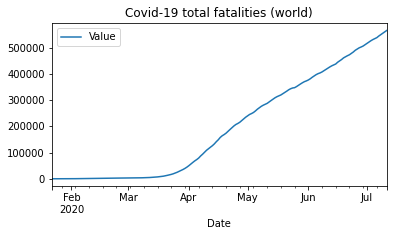

In [ ]:
covid_data.groupby("Date").sum()[["Value"]].plot(figsize=(6, 3), title="Covid-19 total fatalities (world)");

## Plotting

In [ ]:
#Original
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")
    print(f"Ro start: {R_0[0]}, end: {R_0[-1]}, avg:{(R_0[0] + R_0[-1])/2}")


    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        print(len(t),len(x_ticks),x_ticks[0])
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text(f'{country}: Extended SIR') # country global, name before

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    ax.grid(True)
    
    
    # custom grid appearance
    ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
    for tic in ax.xaxis.get_major_ticks():
      tic.tick1On = tic.tick2On = False
    for tic in ax.yaxis.get_major_ticks():
      tic.tick1On = tic.tick2On = False
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    # ax.set_xlim(60, 170)

    plt.show();
    
    f = plt.figure(figsize=(20,4))
    # sp1
    # ax1 = f.add_subplot(131)
    # if x_ticks is None:
    #     ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    # else:
    #     ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    #     ax1.xaxis.set_major_locator(mdates.YearLocator())
    #     ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    #     ax1.xaxis.set_minor_locator(mdates.MonthLocator())
    #     f.autofmt_xdate()

 
    # ax1.title.set_text('R_0 over time')
    # ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    # legend = ax1.legend()
    # legend.get_frame().set_alpha(0.5)
    # for spine in ('top', 'right', 'bottom', 'left'):
    #     ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='Total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='Daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='Total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='Daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    #add in
    # labels = ["February", "March","April", "May", "June", "July", "August"]
    # ax2.set_xticks([30, 60, 85,115,145,175,200])
    # ax2.set_xticklabels(labels)
    #########
    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    ax2.grid(True)
    # custom grid appearance
    ax2.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
    for tic in ax2.xaxis.get_major_ticks():
      tic.tick1On = tic.tick2On = False
    for tic in ax2.yaxis.get_major_ticks():
      tic.tick1On = tic.tick2On = False
        
    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='Total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="Over Capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='Total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="Over Capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per Day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    #add in
    # labels = ["February", "March","April", "May", "June", "July", "August"]
    # ax3.set_xticks([30, 60, 85,115,145,175,200])
    # ax3.set_xticklabels(labels)
    #########
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    ax3.grid(True)
    # custom grid appearance
    ax3.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
    for tic in ax3.xaxis.get_major_ticks():
      tic.tick1On = tic.tick2On = False
    for tic in ax3.yaxis.get_major_ticks():
      tic.tick1On = tic.tick2On = False

    plt.show();

<Figure size 432x288 with 0 Axes>

In [ ]:
# plt.gcf().subplots_adjust(bottom=0.15)

# # outline:
# # fig.add_subplot(3, 1, 1)   #top and bottom left
# # fig.add_subplot(3, 1, 2)   #top right
# # fig.add_subplot(3, 2, 5)   #bottom right 
# # fig.add_subplot(3, 2, 6) 

# def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
#     if S_1 is not None and S_2 is not None:
#       print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")
#     print(f"Ro start: {R_0[0]}, end: {R_0[-1]}, avg:{(R_0[0] + R_0[-1])/2}")

#     f = plt.figure()
#     ax = f.add_subplot(3,1,1)#figsize=(10,4))
#     if x_ticks is None:
#         ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
#         ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
#         ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
#         ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
#         ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
#         ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
#     else:
#         print(len(t),len(x_ticks),x_ticks[0])
#         ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
#         ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
#         ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
#         ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
#         ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
#         ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

#         ax.xaxis.set_major_locator(mdates.YearLocator())
#         ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#         ax.xaxis.set_minor_locator(mdates.MonthLocator())
#         f.autofmt_xdate()


#     ax.title.set_text(f'{country}: Extended SIR') # country global, name before

#     ax.grid(b=True, which='major', c='w', lw=2, ls='-')
#     legend = ax.legend()
#     legend.get_frame().set_alpha(0.5)
#     ax.grid(True)
#     # custom grid appearance
#     ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
#     for tic in ax.xaxis.get_major_ticks():
#       tic.tick1On = tic.tick2On = False
#     for tic in ax.yaxis.get_major_ticks():
#       tic.tick1On = tic.tick2On = False
#     for spine in ('top', 'right', 'bottom', 'left'):
#         ax.spines[spine].set_visible(False)
#     # ax.set_xlim(60, 170)

#     # plt.show();
    
#     # f = plt.figure(figsize=(10,4))
#     # Bottom half:
#     ax1 = f.add_subplot(3,1,2)#,figsize=(10,4))
#     if x_ticks is None:
#         ax1.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
#         ax1.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
#         ax1.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
#         ax1.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
#         ax1.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
#         ax1.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
#     else:
#         print(len(t),len(x_ticks),x_ticks[0])
#         ax1.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
#         ax1.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
#         ax1.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
#         ax1.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
#         ax1.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
#         ax1.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

#         ax1.xaxis.set_major_locator(mdates.YearLocator())
#         ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#         ax1.xaxis.set_minor_locator(mdates.MonthLocator())
#         f.autofmt_xdate()


#     # ax.title.set_text(f'{country}: Extended SIR') # country global, name before

#     ax.grid(b=True, which='major', c='w', lw=2, ls='-')
#     legend = ax.legend()
#     legend.get_frame().set_alpha(0.5)
#     ax1.grid(True)
#     # custom grid appearance
#     ax1.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
#     for tic in ax1.xaxis.get_major_ticks():
#       tic.tick1On = tic.tick2On = False
#     for tic in ax1.yaxis.get_major_ticks():
#       tic.tick1On = tic.tick2On = False
#     for spine in ('top', 'right', 'bottom', 'left'):
#         ax1.spines[spine].set_visible(False)
#     # ax.set_xlim(60, 170)

#     plt.show();
    
#     # sp1
#     # ax1 = f.add_subplot(131)
#     # if x_ticks is None:
#     #     ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
#     # else:
#     #     ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
#     #     ax1.xaxis.set_major_locator(mdates.YearLocator())
#     #     ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     #     ax1.xaxis.set_minor_locator(mdates.MonthLocator())
#     #     f.autofmt_xdate()

 
#     # ax1.title.set_text('R_0 over time')
#     # ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
#     # legend = ax1.legend()
#     # legend.get_frame().set_alpha(0.5)
#     # for spine in ('top', 'right', 'bottom', 'left'):
#     #     ax.spines[spine].set_visible(False)
    
#     # sp2
#     ax2 = f.add_subplot(325)
#     total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
#     daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
#     if x_ticks is None:
#         ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
#         ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
#     else:
#         ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
#         ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
#         ax2.xaxis.set_major_locator(mdates.YearLocator())
#         ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#         ax2.xaxis.set_minor_locator(mdates.MonthLocator())
#         f.autofmt_xdate()

#     ax2.title.set_text('Fatality Rate (%)')
#     ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
#     legend = ax2.legend()
#     legend.get_frame().set_alpha(0.5)
#     ax2.grid(True)
#     # custom grid appearance
#     ax2.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
#     for tic in ax2.xaxis.get_major_ticks():
#       tic.tick1On = tic.tick2On = False
#     for tic in ax2.yaxis.get_major_ticks():
#       tic.tick1On = tic.tick2On = False
        
#     # # sp3
#     # ax3 = f.add_subplot(133)
#     # newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
#     # if x_ticks is None:
#     #     ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
#     #     ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
#     # else:
#     #     ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
#     #     ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
#     #     ax3.xaxis.set_major_locator(mdates.YearLocator())
#     #     ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     #     ax3.xaxis.set_minor_locator(mdates.MonthLocator())
#     #     f.autofmt_xdate()

#     # ax3.title.set_text('Deaths per day')
#     # ax3.yaxis.set_tick_params(length=0)
#     # ax3.xaxis.set_tick_params(length=0)
#     # ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
#     # legend = ax3.legend()
#     # legend.get_frame().set_alpha(0.5)
#     # ax3.grid(True)
#     # # custom grid appearance
#     # ax3.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
#     # for tic in ax3.xaxis.get_major_ticks():
#     #   tic.tick1On = tic.tick2On = False
#     # for tic in ax3.yaxis.get_major_ticks():
#     #   tic.tick1On = tic.tick2On = False

#     plt.show();

# plotter(*Model(days=500, agegroups=[100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000], 
#                beds_per_100k=50, R_0_start=4.0, k=1.0, x0=60, R_0_end=1.0, 
#                prob_I_to_C=0.05, prob_C_to_D=0.6, s=0.003))

In [ ]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter_top(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    print(f"Ro start: {R_0[0]}, end: {R_0[-1]}, avg:{(R_0[0] + R_0[-1])/2}")

    f, ax = plt.subplots(1,1,figsize=(10,4))
    S,I,R = S/1000000,I/1000000,R/1000000 # make 1 millionth to keep numbers nice
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    else:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')

        # HINT for problem, it *was* in x_ticks instead of t above
        # ax.xaxis.set_major_locator(mdates.YearLocator())
        # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        # ax.xaxis.set_minor_locator(mdates.MonthLocator())
        # f.autofmt_xdate()

    ax.title.set_text(f'{country}: Extended SIR')

    # custom grid appearance
    # ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    ax.grid(True)
    ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
    for tic in ax.xaxis.get_major_ticks():
      tic.tick1On = tic.tick2On = False
    for tic in ax.yaxis.get_major_ticks():
      tic.tick1On = tic.tick2On = False
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    # ax.set_xlim(60, 170)
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(False) 
    ax.set_xticks([30, 60, 85,115,145,175,200]) #blank, but keeps grid
    ax.yaxis.set_major_formatter(formatter) 
    ax.yaxis.set_major_formatter(formatter) 
    plt.ylabel('Number of People (Million)')
    # f.text(0.0, 0.5, 'Number of People (Million)', va='center', ha='center', rotation='vertical', fontsize=rcParams['axes.labelsize'])

    plt.show();
    
    f = plt.figure(figsize=(10,4))



def plotter_bottom(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    print(f"Ro start: {R_0[0]}, end: {R_0[-1]}, avg:{(R_0[0] + R_0[-1])/2}")

    E,I,R,C,D = E/1000000,I/1000000,R/1000000, C/1000000, D/1000000 # make 1 millionth to keep numbers nice

    f, ax = plt.subplots(1,1,figsize=(10,4))
    if x_ticks is None:
        # ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        # ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    labels = ["February", "March","April", "May", "June", "July", "August"]
    ax.set_xticks([30, 60, 85,115,145,175,200])
    ax.set_xticklabels(labels)



    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
    for tic in ax.xaxis.get_major_ticks():
      tic.tick1On = tic.tick2On = False
    for tic in ax.yaxis.get_major_ticks():
      tic.tick1On = tic.tick2On = False
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    # ax.set_xlim(60, 170)
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(False) 
    ax.yaxis.set_major_formatter(formatter) 
    ax.yaxis.set_major_formatter(formatter)

    plt.xlabel('Time (Month)')


    plt.show();
    
    f = plt.figure(figsize=(10,4))


<Figure size 432x288 with 0 Axes>

## Model

In [ ]:
def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N 
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [ ]:
gamma = 1.0/9.0
sigma = 1.0/3.0



def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    # def beta(t):
    #     return logistic_R_0(t, R_0_start, k, x0, R_0_end) / (( 1 - prob_I_to_C) / gamma + prob_I_to_C / (1/12.0))

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

In [ ]:
plotter(*Model(days=500, agegroups=[100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000], 
               beds_per_100k=50, R_0_start=4.0, k=1.0, x0=60, R_0_end=1.0, 
               prob_I_to_C=0.05, prob_C_to_D=0.6, s=0.003))

# TOY SET (Not based on real data)

In [ ]:
plotter_top(*Model(days=500, agegroups=[100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000], 
               beds_per_100k=50, R_0_start=4.0, k=1.0, x0=60, R_0_end=1.0, 
               prob_I_to_C=0.05, prob_C_to_D=0.6, s=0.003))

In [ ]:
plotter_bottom(*Model(days=500, agegroups=[100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000], 
               beds_per_100k=50, R_0_start=4.0, k=1.0, x0=60, R_0_end=1.0, 
               prob_I_to_C=0.05, prob_C_to_D=0.6, s=0.003))

## Fitting

In [ ]:
# plot of age distribution (criticality dpends highly on age groups)
# size = len(agegroup_lookup['Brazil'])
# plt.bar(range(size),agegroup_lookup['Brazil']);

In [ ]:
# Add missing data point for Brazil
beds_lookup['Brazil'] = 4.1  # beds from: http://outbreaknewstoday.com/brazil-covid-19-cases-top-800k-8575-icu-beds-enabled-16142/, population from google search
# this is 8,675 / 209.5 mill = 8675/(2095 hundred thousand)
# beds_lookup # potentially old: https://link.springer.com/article/10.1007/s00134-012-2627-8

In [ ]:
# "United Kingdom" includes more countries than just the UK in great britain, we must remove to maintain accuracy
covid_data[covid_data["Location"] == "United Kingdom"]["Province/State"].unique()
covid_data.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', 'Value',
       'ISO 3166-1 Alpha 3-Codes', 'Region Code', 'Sub-region Code',
       'Intermediate Region Code', 'Location'],
      dtype='object')

## UK SEIRC

In [ ]:
# DATA
country = "United Kingdom"
alt_name = "GBR" #(Usually the same except US instead of "United States")
data = covid_data[covid_data["ISO 3166-1 Alpha 3-Codes"] == alt_name]['Value'].values[::-1] #for UK only (courtesy of the British Empire)
# data = covid_data[covid_data["Location"] == "United Kingdom"]["Value"].values[::-1]
agegroups = agegroup_lookup[country]
beds_per_100k = beds_lookup[country]
outbreak_shift = 0
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                       "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [ ]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6]

In [ ]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"


In [ ]:
result = mod.fit(y_data, params, method=fit_method, x=x_data)

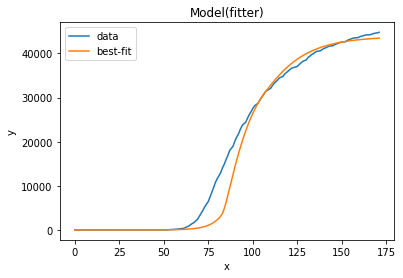

In [ ]:
result.plot_fit(datafmt="-");

In [ ]:
result.best_values

{'R_0_end': 0.3827428604962865,
 'R_0_start': 3.496601867850498,
 'k': 4.05896565714593,
 'prob_C_to_D': 0.7984182764966711,
 'prob_I_to_C': 0.09999999009002343,
 's': 0.001000251376147084,
 'x0': 82.96786035675328}

Prediction for United Kingdom
percentage going to ICU: 9.999999009002343; percentage dying in ICU: 79.84182764966711
Ro start: 3.496601867850498, end: 0.3827428604962865, avg:1.9396723641733924
200 200 2020-01-22 00:00:00


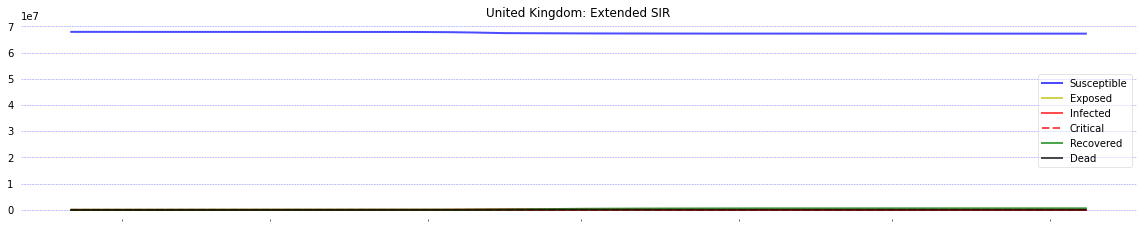

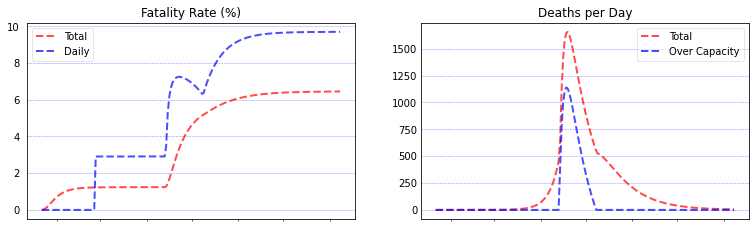

In [ ]:
full_days = 200  # as of July 10th 2020, we are at day ~170, so 200 days is projecting about a month into the future to keep predictions realistic
first_date = np.datetime64(covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print(f"Prediction for {country}")
plotter(*Model(full_days, agegroups, beds_per_100k, **result.best_values), x_ticks=x_ticks);

Ro start: 3.496601867850498, end: 0.3827428604962865, avg:1.9396723641733924


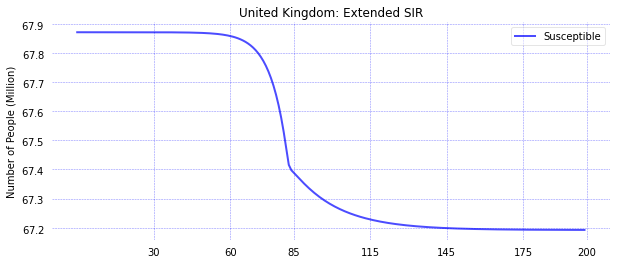

<Figure size 720x288 with 0 Axes>

In [ ]:
plotter_top(*Model(full_days, agegroups, beds_per_100k, **result.best_values), x_ticks=x_ticks);

Ro start: 3.496601867850498, end: 0.3827428604962865, avg:1.9396723641733924


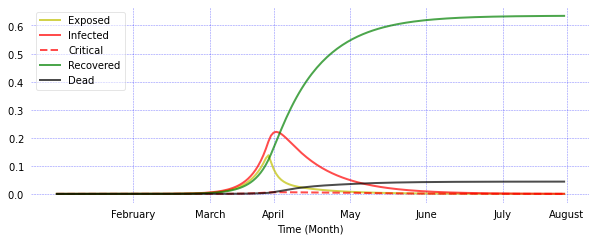

<Figure size 720x288 with 0 Axes>

In [ ]:
plotter_bottom(*Model(full_days, agegroups, beds_per_100k, **result.best_values), x_ticks=x_ticks);

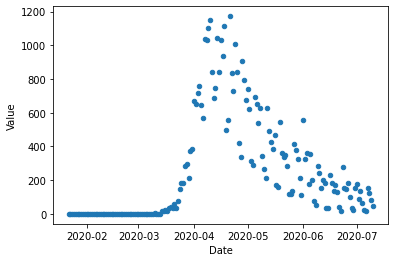

In [ ]:
#plot current deaths per day to confirm consistent with actual data:
# tmp_dat = covid_data[covid_data["Location"] == "United Kingdom"][['Date','Value']]
tmp_dat = covid_data[covid_data["ISO 3166-1 Alpha 3-Codes"] == "GBR"][['Date','Value']] # UK only
tmp_dat.Date = pd.to_datetime(tmp_dat.Date)
tmp_dat.Value = tmp_dat.Value.diff(periods=-1).fillna(0)
tmp_dat.plot.scatter('Date', 'Value');

## Vaccine model (Deprecated)

In [ ]:
# # parameters
# data = covid_data[covid_data["Location"] == "Brazil"]["Value"].values[::-1]
# # data = covid_data[covid_data["ISO 3166-1 Alpha 3-Codes"] == "GBR"]['Value'].values[::-1] #for UK only (courtesy of the British Empire)

# agegroups = agegroup_lookup["Brazil"]
# beds_per_100k = beds_lookup["Brazil"]
# outbreak_shift = 0
# params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
#                        "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
#                        "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [ ]:
def vac_deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
    S, E, I, C, R, D = y
    if t > 100: # After 100 days (arbitrary choice)
        frac = .05 # fraction of susceptible people who take vaccine each day
        num = 10000
        dSdt = -beta(t) * I * S / N - frac*S #- num
        dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C) + frac*S # + num
    else:  
        dSdt = -beta(t) * I * S / N 
        dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)

    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

def vac_Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    # def beta(t):
    #     return logistic_R_0(t, R_0_start, k, x0, R_0_end) / (( 1 - prob_I_to_C) / gamma + prob_I_to_C / (1/12.0))

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(vac_deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

## UK SEIRC Vaccine (Deprecated)

Prediction for United Kingdom
percentage going to ICU: 9.907264845538405; percentage dying in ICU: 79.99738059921046


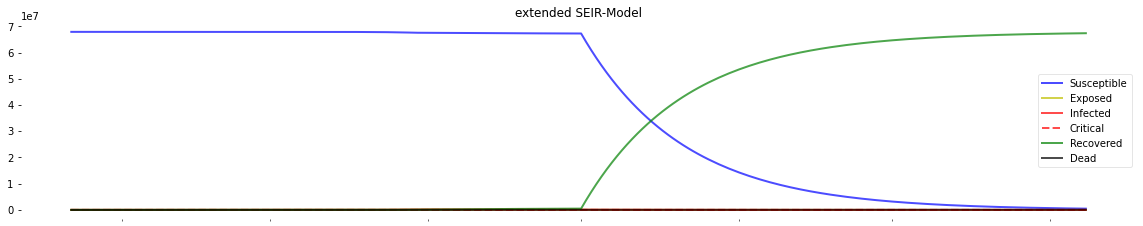

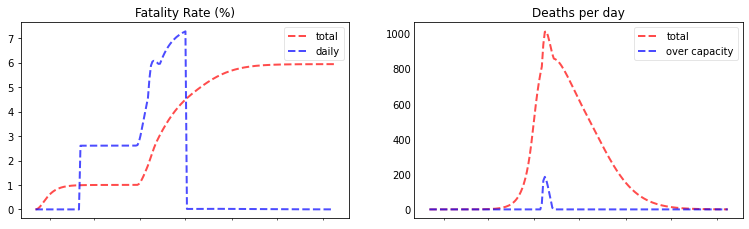

In [ ]:
# def vac_fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
#     ret = vac_Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
#     return ret[6][x]

# vac_mod = lmfit.Model(vac_fitter)

# for kwarg, (init, mini, maxi) in params_init_min_max.items():
#     vac_mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

# params = vac_mod.make_params()
# fit_method = "leastsq"


# vac_result = vac_mod.fit(y_data, params, method=fit_method, x=x_data)

# vac_result.plot_fit(datafmt="-");

# full_days = 200
# first_date = np.datetime64(covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
# x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print(f"Prediction for {country}")
plotter(*vac_Model(full_days, agegroups, beds_per_100k, **result.best_values), x_ticks=x_ticks);

## Mutation Model (Deprecated)

In [ ]:
# # parameters
# country = "Brazil"
# alt_name = "Brazil" #(Usually the same except US instead of "United States")
# data = covid_data[covid_data["Location"] == country]["Value"].values[::-1]
# # data = covid_data[covid_data["ISO 3166-1 Alpha 3-Codes"] == "GBR"]['Value'].values[::-1] #for UK only (courtesy of the British Empire)

# agegroups = agegroup_lookup[alt_name] # US instead of United States, here if applicable
# beds_per_100k = beds_lookup[country]
# outbreak_shift = 0
# params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
#                        "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
#                        "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [ ]:
FLAG = True

def mut_deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):  #If  no change from original deriv in the end, consider removing
    S, E, I, C, R, D = y
    global FLAG
    mutation_date = 150
    if t > mutation_date and FLAG: # After 150 days (arbitrary choice)
        frac = .99 # fraction of recovered individuals who are moved back to susceptible
        dSdt = -beta(t) * I * S / N + frac*R
        dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C) - frac*R
        FLAG = False
    else:  
        dSdt = -beta(t) * I * S / N 
        dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))

      
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt


def mut_Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    # def beta(t):
    #     return logistic_R_0(t, R_0_start, k, x0, R_0_end) / (( 1 - prob_I_to_C) / gamma + prob_I_to_C / (1/12.0))

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(mut_deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T

    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

Prediction for United Kingdom
percentage going to ICU: 9.907264845538405; percentage dying in ICU: 79.99738059921046


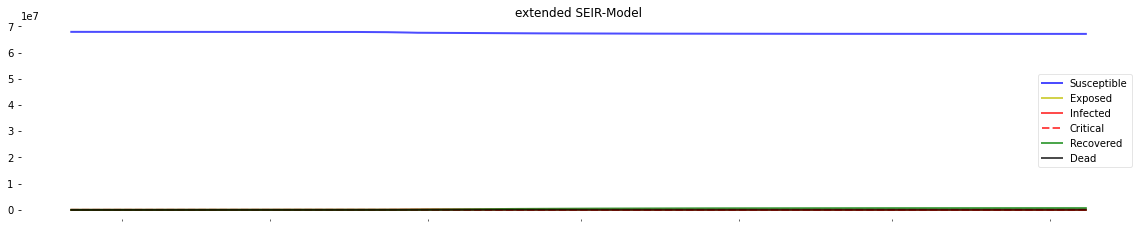

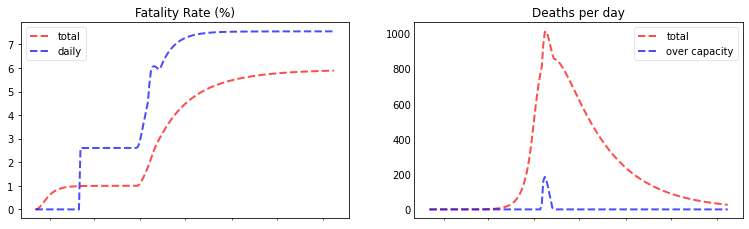

In [ ]:
# def mut_fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
#     ret = mut_Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
#     return ret[6][x]

# mut_mod = lmfit.Model(mut_fitter)

# for kwarg, (init, mini, maxi) in params_init_min_max.items():
#     mut_mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

# params = mut_mod.make_params()
# fit_method = "least_squares"


# mut_result = mut_mod.fit(y_data, params, method=fit_method, x=x_data)

# mut_result.plot_fit(datafmt="-");

# full_days = 200
# first_date = np.datetime64(covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print(f"Prediction for {country}")
plotter(*mut_Model(full_days, agegroups, beds_per_100k, **result.best_values), x_ticks=x_ticks);

-Add confidence interval to plot

[x] Compare death rate (per capita) of black people US vs UK -US,UK,Brazil --disproportionate death rates compared to population ratio (in theory should be the same)

[x] mutation  -- model with changing dS/dt (remove R alltogether https://youtu.be/f1a8JYAixXU?t=601)

[x] Vaccine   -- model with changing dS/dt  (subtract from S add to R https://youtu.be/f1a8JYAixXU?t=513)



## US SEIRC

In [ ]:
# DATA
country = "United States"
alt_name = "US" #(Usually the same except US instead of "United States")
# data = covid_data[covid_data["ISO 3166-1 Alpha 3-Codes"] == alt_name]['Value'].values[::-1] #for UK only (courtesy of the British Empire)
data = covid_data[covid_data["Location"] == alt_name]["Value"].values[::-1]
agegroups = agegroup_lookup[alt_name]
beds_per_100k = beds_lookup[country]

In [ ]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6]

In [ ]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [ ]:
result = mod.fit(y_data, params, method=fit_method, x=x_data)
result.best_values

{'R_0_end': 0.7491442402667219,
 'R_0_start': 4.764573620139429,
 'k': 0.9065379593051904,
 'prob_C_to_D': 0.38609943658025264,
 'prob_I_to_C': 0.09999999978184336,
 's': 0.003,
 'x0': 66.80008288585532}

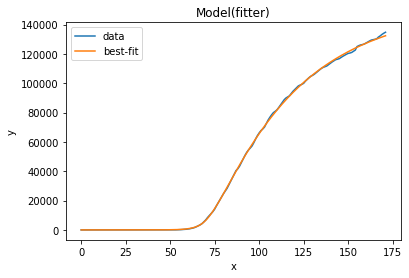

In [ ]:
result.plot_fit(datafmt="-");

Prediction for United States
percentage going to ICU: 9.999999978184336; percentage dying in ICU: 38.609943658025266
Ro start: 4.764573620139428, end: 0.7491442402667219, avg:2.756858930203075
200 200 2020-01-22 00:00:00


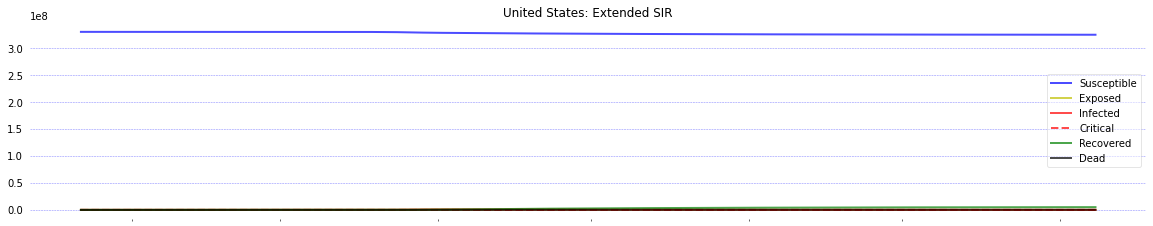

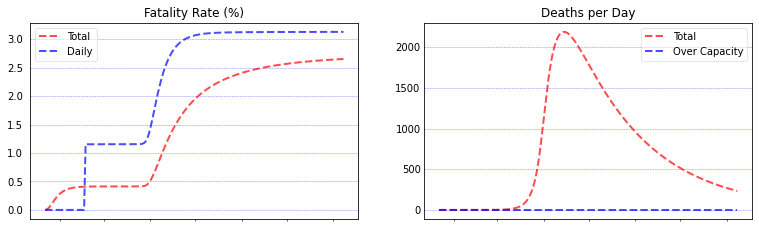

In [ ]:
print(f"Prediction for {country}")
plotter(*Model(full_days, agegroups, beds_per_100k, **result.best_values), x_ticks=x_ticks);

Ro start: 4.764573620139428, end: 0.7491442402667219, avg:2.756858930203075


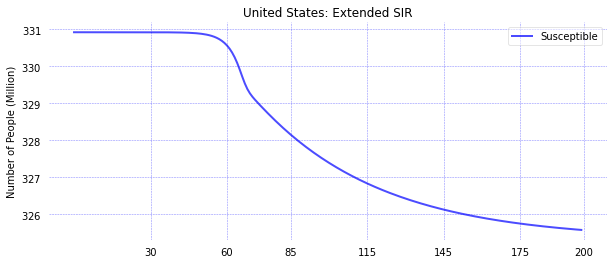

<Figure size 720x288 with 0 Axes>

In [ ]:
plotter_top(*Model(full_days, agegroups, beds_per_100k, **result.best_values), x_ticks=x_ticks);

Ro start: 4.764573620139428, end: 0.7491442402667219, avg:2.756858930203075


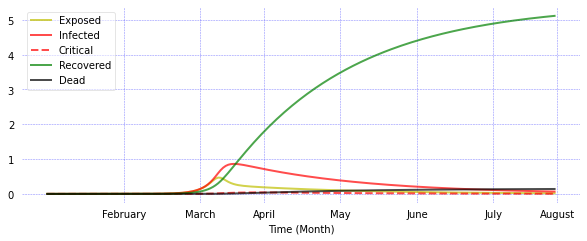

<Figure size 720x288 with 0 Axes>

In [ ]:
plotter_bottom(*Model(full_days, agegroups, beds_per_100k, **result.best_values), x_ticks=x_ticks);

## SEIRC Brazil

In [ ]:
# DATA
country = "Brazil"
alt_name = "Brazil" #(Usually the same except US instead of "United States")
# data = covid_data[covid_data["ISO 3166-1 Alpha 3-Codes"] == alt_name]['Value'].values[::-1] #for UK only (courtesy of the British Empire)
data = covid_data[covid_data["Location"] == alt_name]["Value"].values[::-1]
agegroups = agegroup_lookup[alt_name]
beds_per_100k = beds_lookup[country]
beds_per_100k = beds_lookup['South America']

In [ ]:
days = outbreak_shift + len(data)
if outbreak_shift >= -30:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6]

In [ ]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [ ]:
result = mod.fit(y_data, params, method=fit_method, x=x_data)
result.best_values

{'R_0_end': 2.26826639103489,
 'R_0_start': 2.1447257642921977,
 'k': 0.010000000367145795,
 'prob_C_to_D': 0.7999999998199956,
 'prob_I_to_C': 0.09949508051002236,
 's': 0.0010000000000197438,
 'x0': 58.46365081146225}

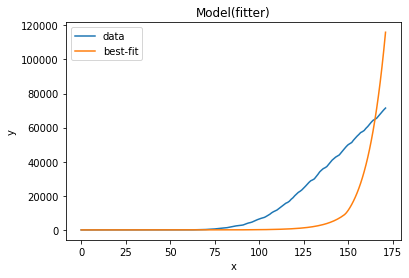

In [ ]:
result.plot_fit(datafmt="-");

Prediction for Brazil
percentage going to ICU: 9.949508051002235; percentage dying in ICU: 79.99999998199957
Ro start: 2.188936807038173, end: 2.2439330413286367, avg:2.216434924183405
200 200 2020-01-22 00:00:00


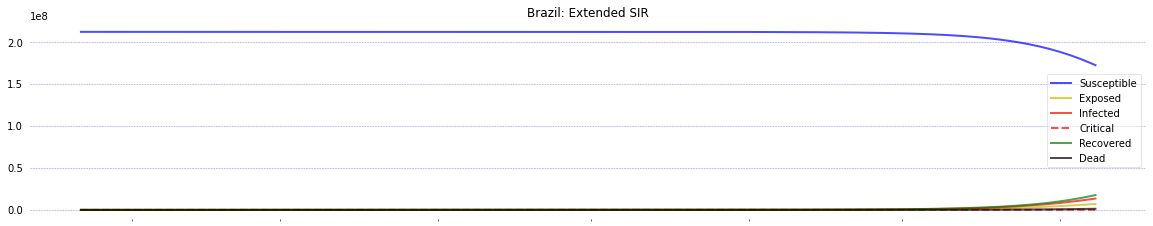

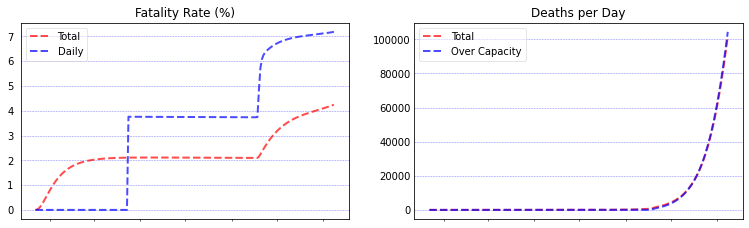

In [ ]:
print(f"Prediction for {country}")
plotter(*Model(full_days, agegroups, beds_per_100k, **result.best_values), x_ticks=x_ticks);

Ro start: 2.188936807038173, end: 2.2439330413286367, avg:2.216434924183405


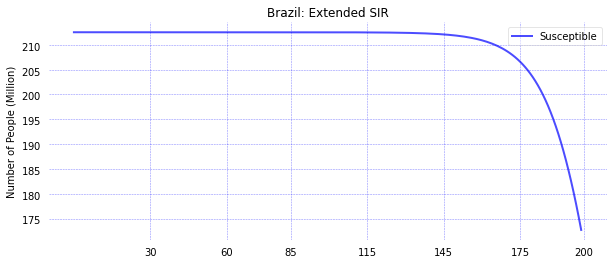

<Figure size 720x288 with 0 Axes>

In [ ]:
plotter_top(*Model(full_days, agegroups, beds_per_100k, **result.best_values), x_ticks=x_ticks);

Ro start: 2.188936807038173, end: 2.2439330413286367, avg:2.216434924183405


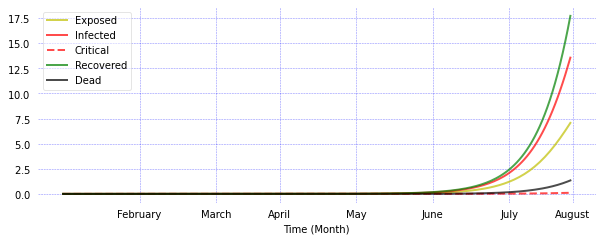

<Figure size 720x288 with 0 Axes>

In [ ]:
plotter_bottom(*Model(full_days, agegroups, beds_per_100k, **result.best_values), x_ticks=x_ticks);

In [ ]:
covid_data[covid_data.Location == 'Brazil']

,Province/State,Country/Region,Lat,Long,Date,Value,ISO 3166-1 Alpha 3-Codes,Region Code,Sub-region Code,Intermediate Region Code,Location
5160,NaN,Brazil,-14.235,-51.9253,2020-07-11,71469,BRA,19.0,419.0,5.0,Brazil
5161,NaN,Brazil,-14.235,-51.9253,2020-07-10,70398,BRA,19.0,419.0,5.0,Brazil
5162,NaN,Brazil,-14.235,-51.9253,2020-07-09,69184,BRA,19.0,419.0,5.0,Brazil
5163,NaN,Brazil,-14.235,-51.9253,2020-07-08,67964,BRA,19.0,419.0,5.0,Brazil
5164,NaN,Brazil,-14.235,-51.9253,2020-07-07,66741,BRA,19.0,419.0,5.0,Brazil
...,...,...,...,...,...,...,...,...,...,...,...
5327,NaN,Brazil,-14.235,-51.9253,2020-01-26,0,BRA,19.0,419.0,5.0,Brazil
5328,NaN,Brazil,-14.235,-51.9253,2020-01-25,0,BRA,19.0,419.0,5.0,Brazil
5329,NaN,Brazil,-14.235,-51.9253,2020-01-24,0,BRA,19.0,419.0,5.0,Brazil
5330,NaN,Brazil,-14.235,-51.9253,2020-01-23,0,BRA,19.0,419.0,5.0,Brazil


# Racial/Ethnic Plots

## US

In [ ]:
import pandas as pd

In [ ]:
# US deaths from Covid
us_dat = "https://docs.google.com/spreadsheets/d/e/2PACX-1vR_xmYt4ACPDZCDJcY12kCiMiH0ODyx3E1ZvgOHB8ae1tRcjXbs_yWBOA4j4uoCEADVfC1PS2jYO68B/pub?gid=43720681&single=true&output=csv"
us_covid_df = pd.read_csv(us_dat)
us_covid_df = us_covid_df[['Deaths_Total','Deaths_White',
       'Deaths_Black', 'Deaths_LatinX', 'Deaths_Asian', 'Deaths_AIAN',
       'Deaths_NHPI', 'Deaths_Multiracial', 'Deaths_Other', 'Deaths_Unknown',
       'Deaths_Ethnicity_Hispanic', 'Deaths_Ethnicity_NonHispanic',
       'Deaths_Ethnicity_Unknown']].fillna(0)

us_covid_df = pd.DataFrame(us_covid_df.sum()).T
us_covid_df = round(us_covid_df / us_covid_df.Deaths_Total[0] * 100,2).drop(columns = ['Deaths_Total'])
us_covid_df = us_covid_df.T.reset_index()
us_covid_df.columns = ['ethnicity', 'percent']
us_covid_df = us_covid_df.loc[[0,1,9,3,6]] # double check later to confirm distribution - adds up to 88 percent
us_covid_df.percent = us_covid_df.percent.apply(lambda x: round(100 * x/us_covid_df.percent.sum(),1))
us_covid_df.ethnicity = ['white','black','hispanic','asian','mixed']
us_covid_df = us_covid_df.reset_index()[['ethnicity','percent']]
us_covid_df

,ethnicity,percent
0,white,54.3
1,black,25.3
2,hispanic,15.7
3,asian,4.5
4,mixed,0.2


In [ ]:
# US Ethnicity distribution
us_census_dat = "https://www.census.gov/quickfacts/fact/table/US/PST045219"
us_census_df = pd.read_html(us_census_dat)
us_census_df = us_census_df[1].iloc[10:18]
us_census_df.columns = ['ethnicity', 'percent']
us_census_df.percent = us_census_df.percent.apply(lambda x: float(''.join(list(x)[2:-1])))
us_census_df = us_census_df.loc[[17,11,16,13,15]]# double check later to confirm distribution
us_census_df.percent = us_census_df.percent.apply(lambda x: round(100 * x/us_census_df.percent.sum(),1)) # normalize (from nearly 100)
us_census_df.ethnicity = ['white','black','hispanic','asian','mixed']
us_census_df = us_census_df.reset_index()[['ethnicity','percent']]
us_census_df

,ethnicity,percent
0,white,59.7
1,black,13.3
2,hispanic,18.4
3,asian,5.9
4,mixed,2.8


In [ ]:
#TODO Find appropriate statistics test
from scipy.stats import ttest_ind
ttest_ind(us_census_df.percent,us_covid_df.percent)

Ttest_indResult(statistic=0.0014189129803428412, pvalue=0.9989026158936025)

In [ ]:
us_df = us_census_df.merge(us_covid_df,on="ethnicity").set_index('ethnicity')
us_df.columns = ['population frequency','killed by Covid']
us_df

,population frequency,killed by Covid
ethnicity,,
white,59.7,54.3
black,13.3,25.3
hispanic,18.4,15.7
asian,5.9,4.5
mixed,2.8,0.2


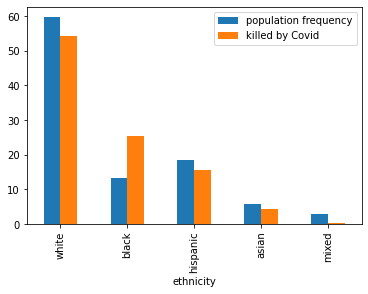

In [ ]:
us_df.plot(kind='bar',);

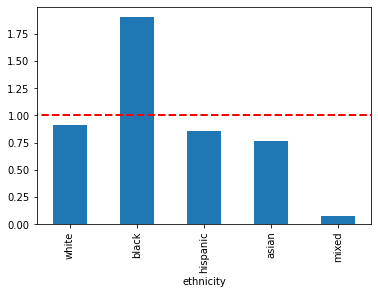

In [ ]:
# normalized, in a "fair world" these would all be close to about 1
temp_us_df = us_df['killed by Covid']/us_df['population frequency']
us_plot = pd.DataFrame(temp_us_df).plot(kind='bar', legend=False)
us_plot.axhline(y=1, xmin=-.15, xmax=1, color='r', linestyle='--', lw=2);
# Red dotted line shows what would be expected if deaths by virus matched population frequency

## UK

In [ ]:
#COVID
!wget "https://www.ons.gov.uk/download/table?format=csv&uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/articles/coronavirusrelateddeathsbyethnicgroupenglandandwales/2march2020to10april2020/60e18f0f.json" -O uk_covid_dat

--2020-07-12 22:25:57--  https://www.ons.gov.uk/download/table?format=csv&uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/articles/coronavirusrelateddeathsbyethnicgroupenglandandwales/2march2020to10april2020/60e18f0f.json
Resolving www.ons.gov.uk (www.ons.gov.uk)... 104.20.32.77, 172.67.34.168, 104.20.31.77, ...
Connecting to www.ons.gov.uk (www.ons.gov.uk)|104.20.32.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 512 [text/csv]
Saving to: ‘uk_covid_dat’

uk_covid_dat        100%[===================>]     512  --.-KB/s    in 0s      

2020-07-12 22:25:57 (75.2 MB/s) - ‘uk_covid_dat’ saved [512/512]



In [ ]:
uk_covid_df = pd.read_csv("./uk_covid_dat",skiprows=4).dropna().loc[:5].drop(columns=['Unnamed: 0','Total'])
uk_covid_df.White = uk_covid_df.White.apply(lambda x: int(x.replace(',','')))
uk_covid_df = pd.DataFrame(uk_covid_df.sum())
uk_covid_df.columns = ['percent']
uk_covid_df = uk_covid_df.percent.apply(lambda x: round(100 * x / uk_covid_df.percent.sum(),1)).reset_index()
uk_covid_df.columns = ['ethnicity','percent']
uk_covid_df.ethnicity = ['white','mixed','indian','bangladeshi_and_pakistani','chinese','black','other']
uk_covid_df

,ethnicity,percent
0,white,83.8
1,mixed,0.7
2,indian,3.8
3,bangladeshi_and_pakistani,3.0
4,chinese,0.5
5,black,6.0
6,other,2.3


In [ ]:
# Demographics
# source: https://www.ethnicity-facts-figures.service.gov.uk/uk-population-by-ethnicity/national-and-regional-populations/population-of-england-and-wales/latest
uk_census_dat = "https://www.ethnicity-facts-figures.service.gov.uk/uk-population-by-ethnicity/national-and-regional-populations/population-of-england-and-wales/latest/downloads/by-ethnicity.csv"
uk_census_df = pd.read_csv(uk_census_dat)
uk_census_df = uk_census_df.set_index('Ethnicity')
uk_census_df.Number = uk_census_df.Number.apply(lambda x: int(x.replace(',','')))
# uk_census_df = uk_census_df[['Ethnicity','%']]
uk_census_df.columns = ['number','percent']
uk_census_df = uk_census_df.T
# To match census data groupings: "Asian other" combined to Other, Bangladeshi and Pakistani combined. White combined, Black combined, mixed combined
uk_census_df.Bangladeshi = uk_census_df[['Bangladeshi', 'Pakistani']].sum(axis=1)
uk_census_df.Other =  uk_census_df[['Other', 'Asian other']].sum(axis=1)
uk_census_df = uk_census_df.drop(columns=['Black African', 'Black Caribbean', 'Black other','Mixed White/Asian',
       'Mixed White/Black African', 'Mixed White/Black Caribbean', 'Mixed other', 'Asian', 'Asian other','Pakistani',
       'White British', 'White Irish','White Gypsy/Traveller', 'White other', 'Arab','Any other','All']) 
uk_census_df.columns= ["bangladeshi_and_pakistani",'chinese','indian','black','mixed','white','other']
uk_census_df = uk_census_df.T.reset_index().drop(columns=['number'])
uk_census_df.columns = ['ethnicity','percent']
uk_census_df

,ethnicity,percent
0,bangladeshi_and_pakistani,2.8
1,chinese,0.7
2,indian,2.5
3,black,3.3
4,mixed,2.2
5,white,86.0
6,other,2.5


In [ ]:
uk_df = uk_census_df.merge(uk_covid_df,on='ethnicity').set_index('ethnicity')
uk_df.columns = ['population frequency','killed by Covid']
uk_df

,population frequency,killed by Covid
ethnicity,,
bangladeshi_and_pakistani,2.8,3.0
chinese,0.7,0.5
indian,2.5,3.8
black,3.3,6.0
mixed,2.2,0.7
white,86.0,83.8
other,2.5,2.3


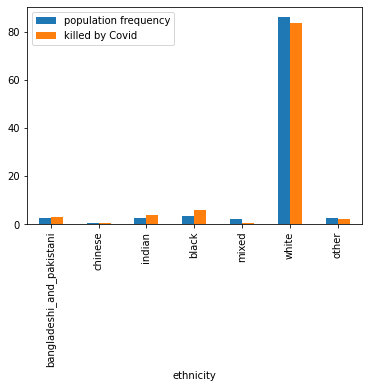

In [ ]:
uk_df.plot(kind='bar',);

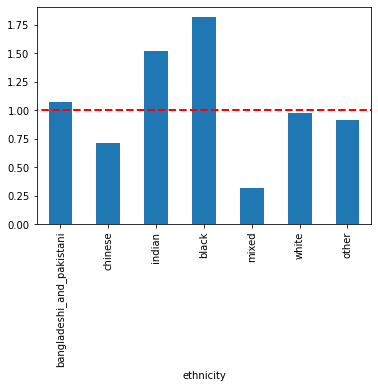

In [ ]:
# normalized, in a "fair world" these would all be close to about 1
temp_uk_df = uk_df['killed by Covid']/uk_df['population frequency']
uk_plot = pd.DataFrame(temp_uk_df).plot(kind='bar', legend=False)
uk_plot.axhline(y=1, xmin=-.15, xmax=1, color='r', linestyle='--', lw=2);

## Brazil

In [ ]:
# Sources tables 1 2: https://www.thelancet.com/journals/langlo/article/PIIS2214-109X(20)30285-0/fulltext#bib12
# pd.read_html("https://www.thelancet.com/action/showFullTableHTML?isHtml=true&tableId=tbl2&pii=S2214-109X%2820%2930285-0")
# !curl "https://www.thelancet.com/action/showFullTableHTML?isHtml=true&tableId=tbl2&pii=S2214-109X%2820%2930285-0"
!wget "https://secure.jbs.elsevierhealth.com/action/getSharedSiteSession?redirect=https%3A%2F%2Fwww.thelancet.com%2Faction%2FshowFullTableHTML%3FisHtml%3Dtrue%26tableId%3Dtbl2%26pii%3DS2214-109X%252820%252930285-0&rc=0" -O tmp_test

--2020-07-12 22:26:26--  https://secure.jbs.elsevierhealth.com/action/getSharedSiteSession?redirect=https%3A%2F%2Fwww.thelancet.com%2Faction%2FshowFullTableHTML%3FisHtml%3Dtrue%26tableId%3Dtbl2%26pii%3DS2214-109X%252820%252930285-0&rc=0
Resolving secure.jbs.elsevierhealth.com (secure.jbs.elsevierhealth.com)... 104.18.124.114, 104.18.123.114
Connecting to secure.jbs.elsevierhealth.com (secure.jbs.elsevierhealth.com)|104.18.124.114|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://secure.jbs.elsevierhealth.com/action/getSharedSiteSession?rc=1&redirect=https%3A%2F%2Fwww.thelancet.com%2Faction%2FshowFullTableHTML%3FisHtml%3Dtrue%26tableId%3Dtbl2%26pii%3DS2214-109X%252820%252930285-0 [following]
--2020-07-12 22:26:26--  https://secure.jbs.elsevierhealth.com/action/getSharedSiteSession?rc=1&redirect=https%3A%2F%2Fwww.thelancet.com%2Faction%2FshowFullTableHTML%3FisHtml%3Dtrue%26tableId%3Dtbl2%26pii%3DS2214-109X%252820%252930285-0
Reusing existing connectio

In [ ]:
import re
def numerize(x):
  allowed = list('0123456789.')
  x = re.sub(r'\([^()]*\)','',x) # removing anything in a parentheses
  x = ''.join([c for c in list(x) if c in allowed]) # keep only numeric content
  if x == '':
    return 0
  return float(x)

brazil_df = pd.read_html('./tmp_test')[0][['Unnamed: 0', 'Brazilian population*','Death']]
brazil_df.columns = ['ethnicity','population','death']
brazil_df = brazil_df.set_index('ethnicity').applymap(lambda x: x.replace("Â·",'.')).applymap(numerize)
brazil_df.iloc[1:6,0] = brazil_df.iloc[1:6,0].apply(lambda x: round(float(x)*20.43))
brazil_df.iloc[7:,0] = brazil_df.iloc[7:,0].apply(lambda x: round(float(x)*92.78))
saved_brazil_df = brazil_df.copy() # pull this out for North/South comparison
brazil_df = brazil_df.T
brazil_df['white'] = brazil_df.White.sum(axis=1)
brazil_df['pardo'] = brazil_df.Pardo.sum(axis=1)
brazil_df['black'] = brazil_df.Black.sum(axis=1)
brazil_df['east_asian'] = brazil_df['East Asian'].sum(axis=1)
brazil_df['indigenous'] = brazil_df.Indigenous.sum(axis=1)
brazil_df = brazil_df[['white', 'pardo', 'black', 'east_asian', 'indigenous']].T
for col in brazil_df.columns:
  brazil_df[col] = brazil_df[col].apply(lambda x: round(x * 100 / brazil_df[col].sum(),1))
brazil_df.columns = ['population frequency','killed by Covid']
brazil_df

,population frequency,killed by Covid
ethnicity,,
white,53.1,51.0
pardo,38.3,39.4
black,7.2,7.4
east_asian,1.1,2.1
indigenous,0.4,0.2


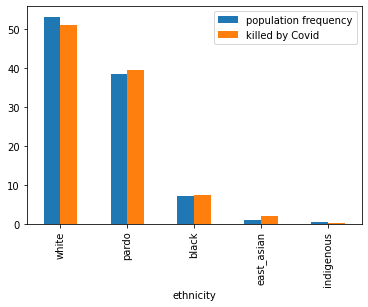

In [ ]:
brazil_df.plot(kind='bar',);

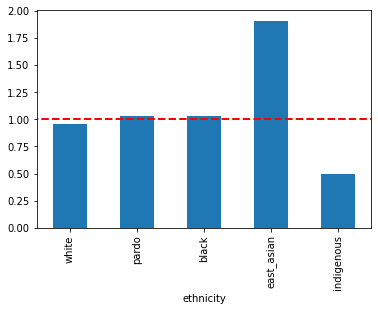

In [ ]:
# normalized, in a "fair world" these would all be close to about 1
temp_brazil_df = brazil_df['killed by Covid']/brazil_df['population frequency']
brazil_plot = pd.DataFrame(temp_brazil_df).plot(kind='bar', legend=False)
brazil_plot.axhline(y=1, xmin=-.15, xmax=1, color='r', linestyle='--', lw=2);

### Brazil North vs South/Central

In [ ]:
saved_brazil_df

,population,death
ethnicity,,
North (n=2043),0.0,0.0
White,568.0,136.0
Pardo,1256.0,683.0
Black,180.0,35.0
East Asian,25.0,12.0
Indigenous,14.0,5.0
Central-south (n=9278),0.0,0.0
White,5446.0,1560.0
Pardo,3080.0,627.0


In [ ]:
brazil_n = saved_brazil_df.iloc[1:6,:]
brazil_sc = saved_brazil_df.iloc[7:,:]
dfs = [brazil_n, brazil_sc]
for df in dfs:
  for col in df.columns:
    df[col] = df[col].apply(lambda x: round(x * 100 / df[col].sum(),1))
  df.columns = ['population frequency','killed by Covid']
brazil_n
# saved_brazil_df

,population frequency,killed by Covid
ethnicity,,
White,27.8,15.6
Pardo,61.5,78.4
Black,8.8,4.0
East Asian,1.2,1.4
Indigenous,0.7,0.6


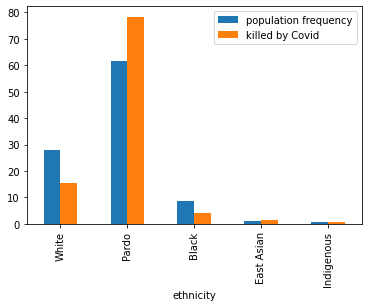

In [ ]:
brazil_n.plot(kind='bar');

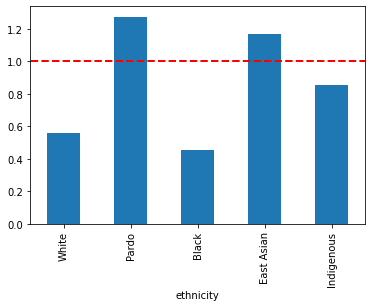

In [ ]:
# normalized, in a "fair world" these would all be close to about 1
temp_brazil_n = brazil_n['killed by Covid']/brazil_n['population frequency']
brazil_plot = pd.DataFrame(temp_brazil_n).plot(kind='bar', legend=False)
brazil_plot.axhline(y=1, xmin=-.15, xmax=1, color='r', linestyle='--', lw=2);

In [ ]:
brazil_sc

,population frequency,killed by Covid
ethnicity,,
White,58.6,63.5
Pardo,33.2,25.5
Black,6.8,8.5
East Asian,1.1,2.3
Indigenous,0.3,0.1


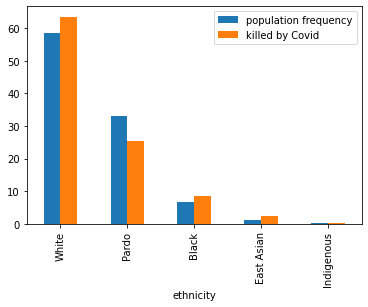

In [ ]:
brazil_sc.plot(kind='bar');

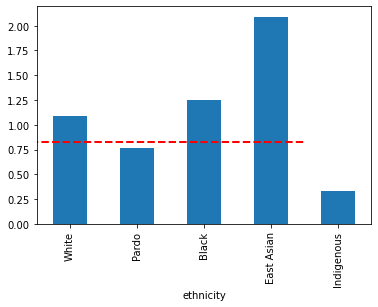

In [ ]:
# normalized, in a "fair world" these would all be close to about 1
temp_brazil_sc = brazil_sc['killed by Covid']/brazil_sc['population frequency']
brazil_plot = pd.DataFrame(temp_brazil_sc).plot(kind='bar', legend=False)
brazil_plot.axhline(y=.83, xmin=-.15, xmax=.8, color='r', linestyle='--', lw=2);

## white-black all countries

In [ ]:
!pip install mpld3
import mpld3
mpld3.enable_notebook()  #Interfere's with matplotlib's axis scaler (symlog and logit unavailable)


     |████████████████████████████████| 1.0MB 3.1MB/s 
  Created wheel for mpld3: filename=mpld3-0.5.1-cp36-none-any.whl size=364065 sha256=75562b8c3bf92148a013eb79ad3f80b675565356c70d34c95a68e16a638a208e
  Stored in directory: /root/.cache/pip/wheels/38/68/06/d119af6c3f9a2d1e123c1f72d276576b457131b3a7bf94e402
Successfully built mpld3


In [ ]:
us_wb = temp_us_df.reset_index().T.iloc[:,:2].T
us_wb
uk_wb = temp_uk_df.reset_index().T .iloc[:,[5,3]].T
b_wb = temp_brazil_df.reset_index().T.iloc[:,[0,2]].T
wb_df = pd.concat([us_wb,uk_wb,b_wb])
wb_df['country'] = ['US','US','UK','UK','Brazil','Brazil']
wb_df.columns = ['Ethnicity','proportion','Country']
wb_df.proportion = wb_df.proportion.astype(float)
wb_df = wb_df.pivot_table(values='proportion', index='Country', columns ='Ethnicity') # capitalize for styling
# rearrange for order preference
wb_df = wb_df.sort_index(ascending=False)
wb_df = wb_df[['white','black']]
wb_df = wb_df.rename(columns = {'white':'White','black':'Black'})
wb_df

Ethnicity,White,Black
Country,,
US,0.909548,1.902256
UK,0.974419,1.818182
Brazil,0.960452,1.027778


In [ ]:
wb_df.columns

Index(['white', 'black'], dtype='object', name='Ethnicity')

In [ ]:
# us_wb = temp_us_df.reset_index().T.iloc[:,:2].T
# us_wb
# uk_wb = temp_uk_df.reset_index().T .iloc[:,[5,3]].T
# b_wb = temp_brazil_df.reset_index().T.iloc[:,[0,2]].T
# wb_df = pd.concat([us_wb,uk_wb,b_wb])
# wb_df['country'] = ['US','US','UK','UK','Brazil','Brazil']
# wb_df.columns = ['Ethnicity','proportion','Country']
# wb_df.proportion = wb_df.proportion.astype(float)
# wb_df = wb_df.pivot_table(values='proportion', index='Country', columns ='Ethnicity') # capitalize for styling
# # rearrange for order preference
# wb_df = wb_df.sort_index(ascending=False)
# wb_df = wb_df[['white','black']]
# wb_df.columns = ['White','Black']   ##### WEIRD GLITCH BY RENAMING HERE INSTEAD OF USING '.rename'
# wb_df

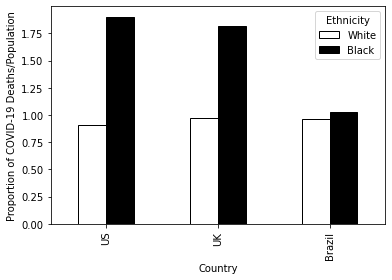

In [ ]:
wb_df.plot(kind='bar', color=['white','black'], edgecolor='black' ).set_ylabel("Proportion of COVID-19 Deaths/Population");#.legend(title='title');
# ax.legend(title='This is My Legend Title')
# dir(a)

In [ ]:
wb_df_no_brazil = wb_df.drop(index='Brazil')
wb_df_no_brazil

Ethnicity,White,Black
Country,,
US,0.909548,1.902256
UK,0.974419,1.818182


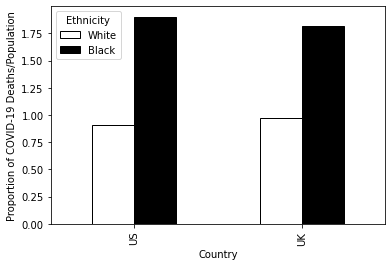

In [ ]:
wb_df_no_brazil.plot(kind='bar', color=['white','black'], edgecolor='black' ).set_ylabel("Proportion of COVID-19 Deaths/Population");

#### Nicer styleing (but have to screen shot)

/usr/local/lib/python3.6/dist-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)
/usr/local/lib/python3.6/dist-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)
/usr/local/lib/python3.6/dist-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)


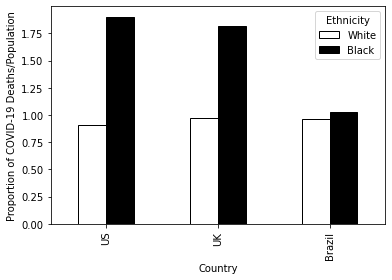

In [ ]:
wb_df.plot(kind='bar', color=['white','black'], edgecolor='black' ).set_ylabel("Proportion of COVID-19 Deaths/Population");#.legend(title='title');

/usr/local/lib/python3.6/dist-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)
/usr/local/lib/python3.6/dist-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)


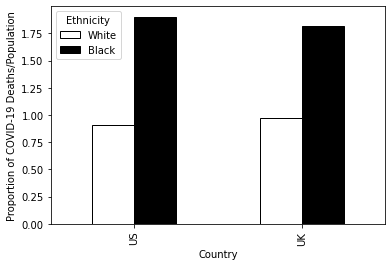

In [ ]:
wb_df_no_brazil.plot(kind='bar', color=['white','black'], edgecolor='black' ).set_ylabel("Proportion of COVID-19 Deaths/Population");


# Co-morbidities

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set(style="white")
np.random.seed(1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## UK co-morbidity

In [ ]:
uk_haz_data = {
    'Hypertension': [.89,.85,.93],
    'Diabetes': [1.9,1.72,2.09],
    'Pulmonary Disease':[1.63,1.55,1.71],
    'Cancer':[2.46,2.06,2.96],
    'Pardo/Mixed': [1.43,1.11,1.85],
    'Asian': [1.44,1.32,1.58],
    'Black': [1.48,1.3,1.69]}

br_haz_data = {
    'Hypertension': [1.02,.95,1.1],
    'Diabetes': [1.18,1.09,1.27],
    'Pulmonary Disease':[1.21,1.06,1.38],
    'Cancer':[1.16,1,1.36],
    'Pardo/Mixed': [1.45,1.33,1.58],
    'Black': [1.32,1.15,1.52],
    'Asian': [1.12,.88,1.44]}

uk_hazard_data_sorted = {k:v for k,v in sorted(uk_haz_data.items(), key=lambda item: item[1][0])[::-1]}
br_hazard_data_sorted = br_haz_data # no sorting? Maybe they will pair automatically... let's try

hazard_df = pd.DataFrame(columns=['hazard', 'values', 'country']) # Initialize df

for country, haz_dat in {'UK': uk_hazard_data_sorted, 'Brazil': br_hazard_data_sorted}.items():
  print('country:', country)
  for k,v in haz_dat.items():
    hazard = k
    mean = v[0]
    bot = v[1]
    top = v[2]
    values = np.random.normal(mean, 2*(top-bot),500)
    hazard = np.array([hazard]*len(values))
    # print(values.shape,hazard.shape)
    print(hazard[0], values.mean())
    sub_hazard_df = pd.DataFrame({'hazard':hazard, 'values':values, 'country': country})
    hazard_df = pd.concat([hazard_df, sub_hazard_df])

print(hazard_df.shape)
hazard_df.head()

country: UK
Cancer 2.556186409661352
Diabetes 1.9178991629665438
Pulmonary Disease 1.6548933698382493
Black 1.4619501027148087
Asian 1.4329129373039209
Pardo/Mixed 1.3845518988080638
Hypertension 0.8957710392053221
country: Brazil
Hypertension 1.0113385331587847
Diabetes 1.1981750632887107
Pulmonary Disease 1.272313896135413
Cancer 1.1474887446248638
Pardo/Mixed 1.408250764418986
Black 1.3249438118720116
Asian 1.0762790422416306
(7000, 3)


,hazard,values,country
0,Cancer,5.383822,UK
1,Cancer,1.358838,UK
2,Cancer,1.509291,UK
3,Cancer,0.528656,UK
4,Cancer,4.017734,UK


In [ ]:
# Separate ethnicities from diseases
ethnicity_hazard_df = hazard_df[hazard_df.hazard.isin(['Pardo/Mixed','Black','Asian'])]
disease_hazard_df = hazard_df[hazard_df.hazard.isin(['Hypertension', 'Diabetes', 'Pulmonary Disease', 'Cancer'])]

ethnicity_hazard_df.columns = ['Ethnicity', 'Hazard Ratio', 'Country']
disease_hazard_df.columns = ['Comorbidity', 'Hazard Ratio', 'Country']

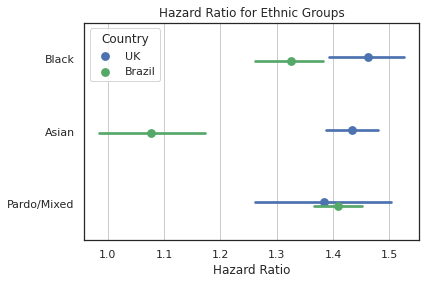

In [ ]:
fig, ax = plt.subplots(1, 1)

sb.pointplot('Hazard Ratio', 'Ethnicity', hue='Country',
    data=ethnicity_hazard_df, join=False, dodge=True, palette=["C0", "C2"]).set_title("Hazard Ratio for Ethnic Groups")

ax.set_ylabel('')
ax.xaxis.grid();

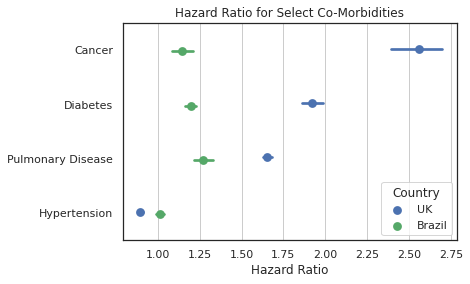

In [ ]:
fig, ax = plt.subplots(1, 1)
sb.pointplot('Hazard Ratio', 'Comorbidity', hue='Country',
    data=disease_hazard_df, join=False, dodge=True, palette=["C0", "C2"]).set_title("Hazard Ratio for Select Co-Morbidities");
ax.set_ylabel('')
ax.xaxis.grid();

## TODO

- [ ] ?Find a statistical test to showcase difference between black americans and black brits

- [x] comorbidities
    https://www.nature.com/articles/s41586-020-2521-4_reference.pdf?referringSource=articleShare

    https://github.com/opensafely/risk-factors-research

    - [x] high blood pressure
    - [x] cancer
    - [x] lung disease
    - [x] diabetes